# 1. Dask

## 1.1 Delayed parallelize

In [1]:
from dask.distributed import Client
client = Client(n_workers = 4)

In [2]:
from time import sleep 

def inc(x):
    sleep(1)
    return x + 1
def add(x,y):
    sleep(1)
    return x + y

In [3]:
%%time 

x = inc(1)
y = inc(2)
z = add(x,y)

CPU times: user 124 ms, sys: 23.7 ms, total: 148 ms
Wall time: 3.01 s


In [4]:
from dask import delayed 

In [5]:
%%time 

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x,y)

CPU times: user 1.03 ms, sys: 842 µs, total: 1.87 ms
Wall time: 1.31 ms


In [6]:
%%time 
z.compute()

CPU times: user 59.8 ms, sys: 10.1 ms, total: 69.9 ms
Wall time: 2.02 s


5

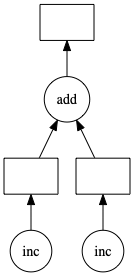

In [7]:
z.visualize()

### Parallelize for loop 

In [8]:
data = [1,2,3,4,5,6,7,8]

In [9]:
%%time 

results = []
for x in data:
    y = inc(x)
    results.append(y)
total = sum(results)

CPU times: user 168 ms, sys: 27.9 ms, total: 196 ms
Wall time: 8.02 s


In [10]:
%%time

results = []
for x in data:
    y = delayed(inc)(x)
    results.append(y)
total = delayed(sum)(results)

CPU times: user 1.81 ms, sys: 1.4 ms, total: 3.21 ms
Wall time: 2.17 ms


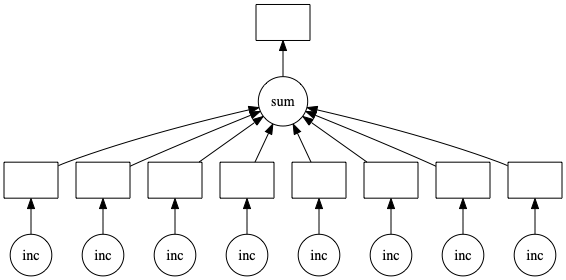

In [11]:
total.visualize()

### Parallelize for loop with control flow

In [12]:
def double(x):
    sleep(1)
    return 2 * x
def is_even(x):
    return not x % 2
data = [1,2,3,4,5,6,7,8,9,10]

In [13]:
%%time 

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
total = sum(results)

CPU times: user 366 ms, sys: 66.1 ms, total: 432 ms
Wall time: 10 s


In [14]:
%%time 

results = []
for x in data:
    if is_even(x):
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    results.append(y)
total = delayed(sum)(results)

CPU times: user 1.08 ms, sys: 1.04 ms, total: 2.12 ms
Wall time: 1.31 ms


In [15]:
total.compute()

90

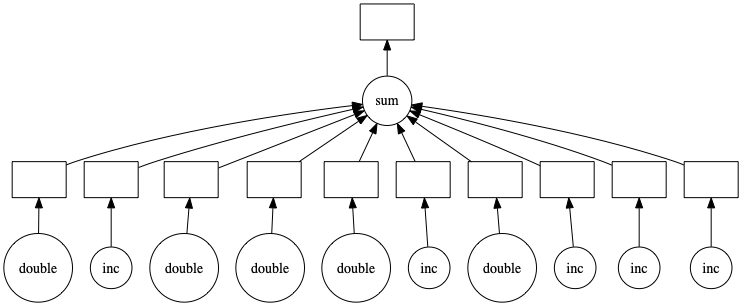

In [16]:
total.visualize()

### Parallelize pandas GroupBy reduction

In [17]:
%run prep.py -d flights

In [18]:
import os
sorted(os.listdir(os.path.join('data','nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

In [19]:
import pandas as pd
df = pd.read_csv(os.path.join('data','nycflights','1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [20]:
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

In [21]:
from glob import glob 
filenames = sorted(glob(os.path.join('data','nycflights','*.csv')))
filenames

['data/nycflights/1990.csv',
 'data/nycflights/1991.csv',
 'data/nycflights/1992.csv',
 'data/nycflights/1993.csv',
 'data/nycflights/1994.csv',
 'data/nycflights/1995.csv',
 'data/nycflights/1996.csv',
 'data/nycflights/1997.csv',
 'data/nycflights/1998.csv',
 'data/nycflights/1999.csv']

In [22]:
%%time 

sums = []
counts = []

for fn in filenames:
    df = pd.read_csv(fn)
    by_origin = df.groupby('Origin')
    total = by_origin.DepDelay.sum()
    count = by_origin.DepDelay.count()
    sums.append(total)
    counts.append(count)
    
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights
mean

CPU times: user 3.65 s, sys: 599 ms, total: 4.25 s
Wall time: 4.19 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [23]:
from dask import compute

In [24]:
%%time 

sums = []
counts = []

for fn in filenames:
    df = delayed(pd.read_csv)(fn)
    by_origin = df.groupby('Origin')
    total = by_origin.DepDelay.sum()
    count = by_origin.DepDelay.count()
    sums.append(total)
    counts.append(count)
sums, counts = compute(sums, counts)
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights
mean

CPU times: user 99.1 ms, sys: 16 ms, total: 115 ms
Wall time: 1.5 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [25]:
client.close()

## 1.2 Lazy execution

### Graph execution engine 

In [26]:
from dask import delayed 

@delayed
def inc(x):
    return x + 1

@delayed 
def add(x, y):
    return x + y

In [27]:
x = inc(15)
y = inc(30)
total = add(x, y)
total

Delayed('add-761907cc-110c-4c2b-b207-f48f1d517d48')

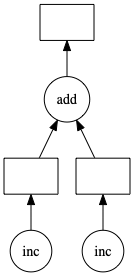

In [28]:
total.visualize()

In [29]:
total.compute()

47

### Data processing example

In [30]:
%run prep.py -d accounts

In [31]:
import pandas as pd
import os

filenames = [os.path.join('data','accounts.%d.csv' % i) for i in [0,1,2]]
filenames

['data/accounts.0.csv', 'data/accounts.1.csv', 'data/accounts.2.csv']

In [32]:
%%time 
a = pd.read_csv(filenames[0])
b = pd.read_csv(filenames[1])
c = pd.read_csv(filenames[2])

na = len(a)
nb = len(b)
nc = len(c)

total = sum([na,nb,nc])
print(total)

3000000
CPU times: user 581 ms, sys: 97.9 ms, total: 679 ms
Wall time: 686 ms


In [33]:
%%time 
a = delayed(pd.read_csv)(filenames[0])
b = delayed(pd.read_csv)(filenames[1])
c = delayed(pd.read_csv)(filenames[2])

na = delayed(len)(a)
nb = delayed(len)(b)
nc = delayed(len)(c)

total = delayed(sum)([na,nb,nc])
print(total.compute())

3000000
CPU times: user 622 ms, sys: 145 ms, total: 766 ms
Wall time: 359 ms


In [34]:
%%time 
csvs = [delayed(pd.read_csv)(fn) for fn in filenames]
lens = [delayed(len)(csv) for csv in csvs]
total = delayed(sum)(lens)
print(total.compute())

3000000
CPU times: user 640 ms, sys: 148 ms, total: 788 ms
Wall time: 374 ms


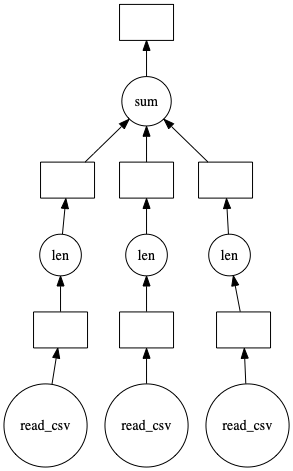

In [35]:
total.visualize()

## 1.3 Bag - parallel lists for semi-structured data

### Create

In [36]:
%run prep.py -d accounts

In [37]:
from dask.distributed import Client 
client = Client(n_workers = 4)

In [38]:
import dask.bag as db 
b = db.from_sequence([1,2,3,4,5,6,7,8,9,10], npartitions = 2)
b.take(3)

(1, 2, 3)

In [39]:
import os
b = db.read_text(os.path.join('data','accounts.*.json.gz'))
b.take(1)

('{"id": 0, "name": "Hannah", "transactions": [{"transaction-id": 791, "amount": -574}, {"transaction-id": 1407, "amount": -495}, {"transaction-id": 1524, "amount": -727}, {"transaction-id": 1640, "amount": -661}, {"transaction-id": 1695, "amount": -737}, {"transaction-id": 1706, "amount": -768}, {"transaction-id": 2552, "amount": -624}, {"transaction-id": 4078, "amount": -643}, {"transaction-id": 4193, "amount": -678}, {"transaction-id": 4305, "amount": -590}, {"transaction-id": 4342, "amount": -696}, {"transaction-id": 5162, "amount": -706}, {"transaction-id": 5367, "amount": -519}, {"transaction-id": 6837, "amount": -727}, {"transaction-id": 7228, "amount": -693}, {"transaction-id": 7773, "amount": -761}, {"transaction-id": 8949, "amount": -724}, {"transaction-id": 8985, "amount": -694}, {"transaction-id": 10572, "amount": -569}, {"transaction-id": 10875, "amount": -574}, {"transaction-id": 11190, "amount": -568}, {"transaction-id": 11334, "amount": -680}, {"transaction-id": 12318, 

In [40]:
import sources
sources.bag_url

's3://dask-data/nyc-taxi/2015/yellow_tripdata_2015-01.csv'

### Manipulate

In [41]:
def is_even(n):
    return n % 2 == 0
b = db.from_sequence([1,2,3,4,5,6,7,8,9,10])
c = b.filter(is_even).map(lambda x: x ** 2)
c

dask.bag<lambda, npartitions=10>

In [42]:
c.compute()

[4, 16, 36, 64, 100]

In [43]:
filename = os.path.join('data','accounts.*.json.gz')
lines = db.read_text(filename)
lines.take(3)

('{"id": 0, "name": "Hannah", "transactions": [{"transaction-id": 791, "amount": -574}, {"transaction-id": 1407, "amount": -495}, {"transaction-id": 1524, "amount": -727}, {"transaction-id": 1640, "amount": -661}, {"transaction-id": 1695, "amount": -737}, {"transaction-id": 1706, "amount": -768}, {"transaction-id": 2552, "amount": -624}, {"transaction-id": 4078, "amount": -643}, {"transaction-id": 4193, "amount": -678}, {"transaction-id": 4305, "amount": -590}, {"transaction-id": 4342, "amount": -696}, {"transaction-id": 5162, "amount": -706}, {"transaction-id": 5367, "amount": -519}, {"transaction-id": 6837, "amount": -727}, {"transaction-id": 7228, "amount": -693}, {"transaction-id": 7773, "amount": -761}, {"transaction-id": 8949, "amount": -724}, {"transaction-id": 8985, "amount": -694}, {"transaction-id": 10572, "amount": -569}, {"transaction-id": 10875, "amount": -574}, {"transaction-id": 11190, "amount": -568}, {"transaction-id": 11334, "amount": -680}, {"transaction-id": 12318, 

In [44]:
import json 
js = lines.map(json.loads)
js.take(3)

({'id': 0,
  'name': 'Hannah',
  'transactions': [{'transaction-id': 791, 'amount': -574},
   {'transaction-id': 1407, 'amount': -495},
   {'transaction-id': 1524, 'amount': -727},
   {'transaction-id': 1640, 'amount': -661},
   {'transaction-id': 1695, 'amount': -737},
   {'transaction-id': 1706, 'amount': -768},
   {'transaction-id': 2552, 'amount': -624},
   {'transaction-id': 4078, 'amount': -643},
   {'transaction-id': 4193, 'amount': -678},
   {'transaction-id': 4305, 'amount': -590},
   {'transaction-id': 4342, 'amount': -696},
   {'transaction-id': 5162, 'amount': -706},
   {'transaction-id': 5367, 'amount': -519},
   {'transaction-id': 6837, 'amount': -727},
   {'transaction-id': 7228, 'amount': -693},
   {'transaction-id': 7773, 'amount': -761},
   {'transaction-id': 8949, 'amount': -724},
   {'transaction-id': 8985, 'amount': -694},
   {'transaction-id': 10572, 'amount': -569},
   {'transaction-id': 10875, 'amount': -574},
   {'transaction-id': 11190, 'amount': -568},
   {'t

In [45]:
js.filter(lambda record: record['name'] == 'Alice').take(5)

({'id': 7,
  'name': 'Alice',
  'transactions': [{'transaction-id': 1871, 'amount': 35},
   {'transaction-id': 2755, 'amount': 77},
   {'transaction-id': 3935, 'amount': 122},
   {'transaction-id': 4355, 'amount': 51},
   {'transaction-id': 5441, 'amount': 31},
   {'transaction-id': 5541, 'amount': 35},
   {'transaction-id': 9534, 'amount': 93},
   {'transaction-id': 10338, 'amount': -27},
   {'transaction-id': 10381, 'amount': 13},
   {'transaction-id': 14003, 'amount': 40},
   {'transaction-id': 14424, 'amount': 105},
   {'transaction-id': 15512, 'amount': 15},
   {'transaction-id': 15597, 'amount': 74},
   {'transaction-id': 16733, 'amount': 106},
   {'transaction-id': 18987, 'amount': 43},
   {'transaction-id': 19334, 'amount': 95},
   {'transaction-id': 19667, 'amount': 107},
   {'transaction-id': 20421, 'amount': 118},
   {'transaction-id': 20452, 'amount': 123},
   {'transaction-id': 20861, 'amount': 12},
   {'transaction-id': 21507, 'amount': 73},
   {'transaction-id': 23120, '

In [46]:
def count_transactions(d):
    return {'name':d['name'], 'count':len(d['transactions'])}

(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .take(5))

({'name': 'Alice', 'count': 96},
 {'name': 'Alice', 'count': 50},
 {'name': 'Alice', 'count': 329},
 {'name': 'Alice', 'count': 46},
 {'name': 'Alice', 'count': 278})

In [47]:
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .take(5))

(96, 50, 329, 46, 278)

In [48]:
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .mean()
   .compute())

210.04714285714286

In [49]:
js.filter(lambda record: record['name'] == 'Alice').pluck('transactions').take(3)

([{'transaction-id': 1871, 'amount': 35},
  {'transaction-id': 2755, 'amount': 77},
  {'transaction-id': 3935, 'amount': 122},
  {'transaction-id': 4355, 'amount': 51},
  {'transaction-id': 5441, 'amount': 31},
  {'transaction-id': 5541, 'amount': 35},
  {'transaction-id': 9534, 'amount': 93},
  {'transaction-id': 10338, 'amount': -27},
  {'transaction-id': 10381, 'amount': 13},
  {'transaction-id': 14003, 'amount': 40},
  {'transaction-id': 14424, 'amount': 105},
  {'transaction-id': 15512, 'amount': 15},
  {'transaction-id': 15597, 'amount': 74},
  {'transaction-id': 16733, 'amount': 106},
  {'transaction-id': 18987, 'amount': 43},
  {'transaction-id': 19334, 'amount': 95},
  {'transaction-id': 19667, 'amount': 107},
  {'transaction-id': 20421, 'amount': 118},
  {'transaction-id': 20452, 'amount': 123},
  {'transaction-id': 20861, 'amount': 12},
  {'transaction-id': 21507, 'amount': 73},
  {'transaction-id': 23120, 'amount': 77},
  {'transaction-id': 23989, 'amount': 14},
  {'transac

In [50]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .take(3))

({'transaction-id': 1871, 'amount': 35},
 {'transaction-id': 2755, 'amount': 77},
 {'transaction-id': 3935, 'amount': 122})

In [51]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .pluck('amount')
   .take(3))

(35, 77, 122)

In [52]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .pluck('amount')
   .mean()
   .compute())

825.0621085062537

In [53]:
b = db.from_sequence(['Alice', 'Bob', 'Charlie', 'Dan', 'Edith', 'Frank'])
b.groupby(len).compute()

[(7, ['Charlie']), (3, ['Bob', 'Dan']), (5, ['Alice', 'Edith', 'Frank'])]

In [54]:
b = db.from_sequence(list(range(10)))
b.groupby(lambda x: x % 2).compute()

[(0, [0, 2, 4, 6, 8]), (1, [1, 3, 5, 7, 9])]

In [55]:
b.groupby(lambda x: x % 2).starmap(lambda k, v: (k, max(v))).compute()

[(0, 8), (1, 9)]

In [56]:
is_even = lambda x: x % 2
b.foldby(is_even, binop=max, combine=max).compute()

[(0, 8), (1, 9)]

### DataFrames

In [57]:
df1 = js.to_dataframe()
df1.head()

,id,name,transactions
0,0,Hannah,"[{'transaction-id': 791, 'amount': -574}, {'tr..."
1,1,Edith,"[{'transaction-id': 1853, 'amount': 833}, {'tr..."
2,2,Ray,"[{'transaction-id': 473, 'amount': 7279}, {'tr..."
3,3,Jerry,"[{'transaction-id': 2134, 'amount': 12}, {'tra..."
4,4,George,"[{'transaction-id': 161, 'amount': 2}, {'trans..."


In [58]:
%time df1.groupby('name').id.count().compute().head()

CPU times: user 474 ms, sys: 29.2 ms, total: 504 ms
Wall time: 1.98 s


name
Alice      700
Bob        650
Charlie    900
Dan        750
Edith      700
Name: id, dtype: int64

## 1.4 Array

### Blocked algorithms

## 1.5 DataFrame


## 1.6 Distributed

## 1.7 Storage

## 1.8 Machine learning